# Y Permutation Test

In [1]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact, cumfreq
from scipy.cluster.hierarchy import linkage, dendrogram
import statsmodels.formula.api as smf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.x_to_a import commonly_expressed

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2019-03-26 
Git hash: c35295f9a025e9719c23faf08a9bc65366505eb0


## Data Prep

In [3]:
clusters = (
    nbconfig.seurat.get_clusters('res.0.6')
    .map(nbconfig.short_cluster_annot)
    .pipe(lambda x: x[x != 'UNK'])
)

clusters.head()

rep1_AAACCTGAGACAAGCC     MC
rep1_AAACCTGAGCTTATCG     MC
rep1_AAACCTGGTGTAATGA     EC
rep1_AAACCTGGTTCATGGT    M1º
rep1_AAACCTGTCCCTCTTT     MC
Name: cluster, dtype: object

In [4]:
mapper = {'chrX': 'X', 'chrY': 'Y', 'chr4': '4', 'chr2L': 'A','chr2R': 'A','chr3L': 'A','chr3R': 'A',}
fbgn2chrom = (
    pd.read_csv('../output/fbgn2chrom.tsv', sep='\t', index_col=0)
    .chrom.map(mapper)
    .dropna()
)
fbgn2chrom.head()

FBgn
FBgn0031081    X
FBgn0052826    X
FBgn0031085    X
FBgn0062565    X
FBgn0031088    X
Name: chrom, dtype: object

In [5]:
num_genes_per_chrom = fbgn2chrom.value_counts()
num_genes_per_chrom

A    14762
X     2669
Y      113
4      111
Name: chrom, dtype: int64

In [6]:
stacked = (
    nbconfig.seurat.get_raw()
    .reset_index()
    .join(fbgn2chrom, on='FBgn')
    .melt(id_vars=['FBgn', 'chrom'], var_name='cell_id', value_name='UMI')
    .join(clusters, on='cell_id')
)

stacked.head()

,FBgn,chrom,cell_id,UMI,cluster
0,FBgn0031081,X,rep1_AAACCTGAGACAAGCC,0,MC
1,FBgn0031085,X,rep1_AAACCTGAGACAAGCC,0,MC
2,FBgn0040784,X,rep1_AAACCTGAGACAAGCC,0,MC
3,FBgn0031086,X,rep1_AAACCTGAGACAAGCC,0,MC
4,FBgn0031082,X,rep1_AAACCTGAGACAAGCC,0,MC


In [7]:
ratios_by_cell = (
    stacked.groupby(['cell_id', 'cluster', 'chrom'])
    .UMI.sum()
    .div(num_genes_per_chrom, level='chrom')
    .mul(1e3)
    .unstack()
    .assign(ratio_x = lambda df: df.X / df.A)
    .assign(ratio_y = lambda df: df.Y / df.A)
    .assign(ratio_4 = lambda df: df['4'] / df.A)
    .drop(['X', 'Y', 'A', '4'], axis=1)
    .reset_index('cluster')
)

ratios_by_cell.head()

chrom,cluster,ratio_x,ratio_y,ratio_4
cell_id,,,,
rep1_AAACCTGAGACAAGCC,MC,0.927737,0.000000,0.106734
rep1_AAACCTGAGCTTATCG,MC,1.409952,0.000000,0.964701
rep1_AAACCTGGTGTAATGA,EC,1.147458,0.000000,1.984940
rep1_AAACCTGGTTCATGGT,M1º,0.537105,0.046048,0.492212
rep1_AAACCTGTCCCTCTTT,MC,1.093753,0.000000,1.195425


/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Y Ratio')

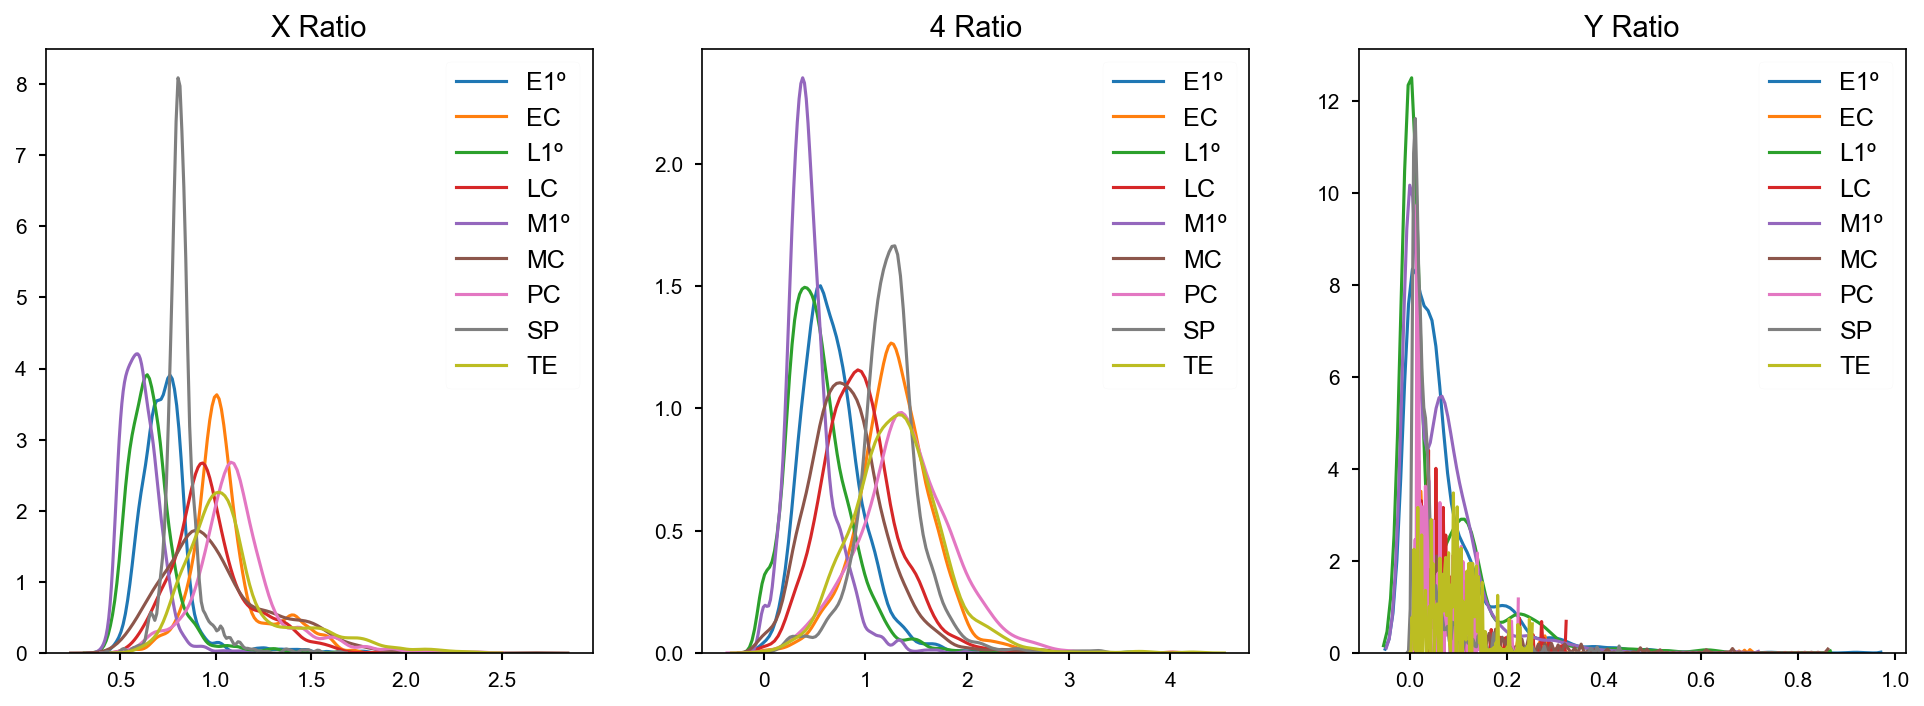

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3))
(
    ratios_by_cell.groupby('cluster')
    .ratio_x.apply(sns.kdeplot, ax=ax1)
)
ax1.set_title('X Ratio')

(
    ratios_by_cell.groupby('cluster')
    .ratio_4.apply(sns.kdeplot, ax=ax2)
)
ax2.set_title('4 Ratio')

(
    ratios_by_cell.groupby('cluster')
    .ratio_y.apply(sns.kdeplot, ax=ax3)
)
ax3.set_title('Y Ratio')

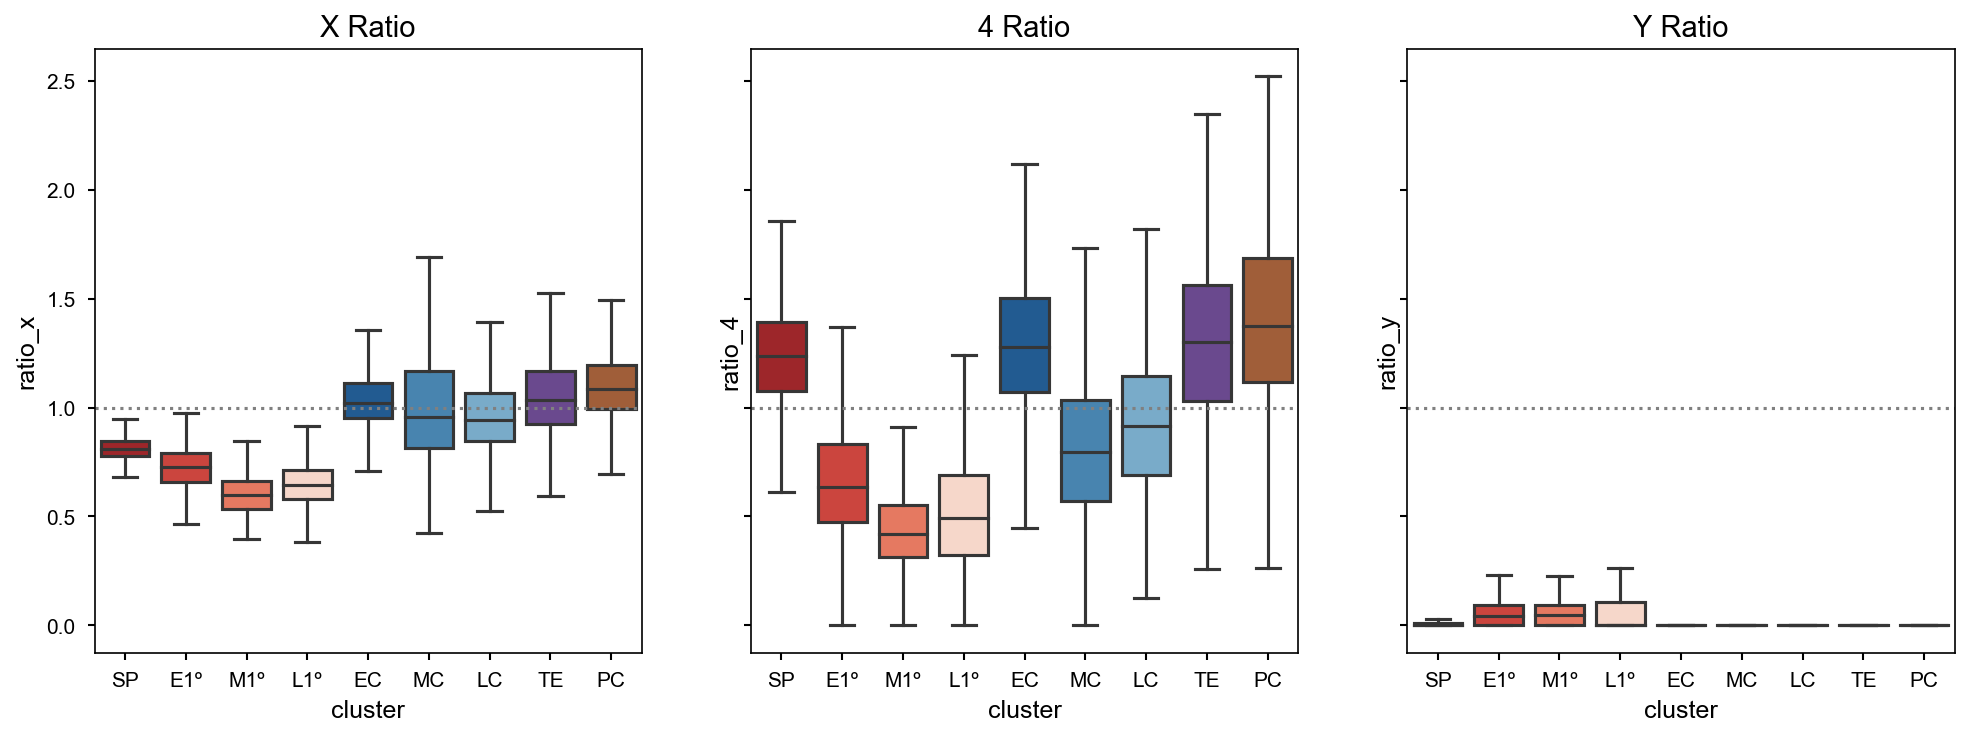

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True, sharex=True)

_defaults = dict(x='cluster', data=ratios_by_cell, order=nbconfig.short_cluster_order, showfliers=False, palette=nbconfig.colors['clusters'])

sns.boxplot(y='ratio_x', ax=ax1, **_defaults)
ax1.set_title('X Ratio')

sns.boxplot(y='ratio_4', ax=ax2, **_defaults)
ax2.set_title('4 Ratio')

sns.boxplot(y='ratio_y', ax=ax3, **_defaults)
ax3.set_title('Y Ratio')

for ax in [ax1, ax2, ax3]:
    ax.axhline(1, ls=':', color='grey')

In [10]:
median_ratios = ratios_by_cell.groupby('cluster').median().reindex(nbconfig.short_cluster_order)

In [14]:
pd.concat([
    (median_ratios.loc['SP'] / median_ratios.loc['E1º']).rename('SP/E1º'), 
    (median_ratios.loc['SP'] / median_ratios.loc['M1º']).rename('SP/M1º'),
    (median_ratios.loc['SP'] / median_ratios.loc['L1º']).rename('SP/L1º')
], axis=1, sort=True)

,SP/E1º,SP/M1º,SP/L1º
chrom,,,
ratio_4,1.951578,2.968011,2.523172
ratio_x,1.116431,1.359742,1.256079
ratio_y,0.000000,0.000000,NaN


In [19]:
(1 / median_ratios.loc[['E1º', 'M1º', 'L1º'], 'ratio_x']).mean()

1.5340932363405233

In [20]:
(1 / median_ratios.loc[['E1º', 'M1º', 'L1º'], 'ratio_4']).mean()

2.0018637232839396

In [15]:
1 / median_ratios

chrom,ratio_x,ratio_y,ratio_4
cluster,,,
SP,1.233111,inf,0.806904
E1º,1.376683,23.026423,1.574735
M1º,1.676712,20.675586,2.394899
L1º,1.548885,inf,2.035957
EC,0.980286,inf,0.782426
MC,1.044971,inf,1.254308
LC,1.059124,inf,1.091262
TE,0.965859,inf,0.768818
PC,0.919445,inf,0.727677


In [ ]:
median_ratios

In [ ]:
cutoff = 0.05

results = []
permuted_ratios_by_cell = ratios_by_cell.copy()
for iteration in range(10_000):
    permuted_ratios_by_cell.cluster = permuted_ratios_by_cell.cluster.sample(frac=1).values
    for clus, observed_ratios in ratios_by_cell.groupby('cluster'):
        permuted_ratios = permuted_ratios_by_cell.query(f'cluster == "{clus}"')
        _, pval_x = mannwhitneyu(observed_ratios.ratio_x, permuted_ratios.ratio_x, alternative='less')
        _, pval_y = mannwhitneyu(observed_ratios.ratio_y, permuted_ratios.ratio_y, alternative='greater')
        _, pval_4 = mannwhitneyu(observed_ratios.ratio_4, permuted_ratios.ratio_4, alternative='less')
        results.append((clus, pval_x <= cutoff, pval_y <= cutoff, pval_4 <= cutoff))

In [ ]:
pvals = 1 - (
    pd.DataFrame(results, columns=['cluster', 'sig_x', 'sig_y', 'sig_4']).groupby('cluster')
    .mean()
    .rename(columns=dict(sig_x='pval_x_lt_a', sig_y='pval_y_gt_a', sig_4='pval_4_lt_a'))
    .loc[nbconfig.short_cluster_order, :]
)
pvals

In [ ]:
def whisker(dat):
    low, high = np.percentile(dat, [25, 75])
    iqr = high - low
    return high + (1.5 * iqr)

In [ ]:
def plot_pval(dat, pvals, ax):
    whiskers = (
        dat.groupby('cluster')
        .apply(whisker)
        .to_dict()
    )
    
    for i, clus in enumerate(nbconfig.short_cluster_order):
        pval = pvals.loc[clus]
        loc = whiskers[clus]
        
        if pval <= 0.001:
            ax.text(i, loc, '***', ha='center', va='bottom')
        elif pval <= 0.01:
            ax.text(i, loc, '**', ha='center', va='bottom')
        elif pval <= 0.05:
            ax.text(i, loc, '*', ha='center', va='bottom')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)

_defaults = dict(x='cluster', data=ratios_by_cell, order=nbconfig.short_cluster_order, showfliers=False, palette=nbconfig.colors['clusters'])

sns.boxplot(y='ratio_x', ax=axes[0], **_defaults)
plot_pval(ratios_by_cell[['cluster', 'ratio_x']], pvals.pval_x_lt_a, axes[0])
axes[0].text(.01, .95, '* X < A', transform=axes[0].transAxes, fontsize=14)


sns.boxplot(y='ratio_4', ax=axes[1], **_defaults)
plot_pval(ratios_by_cell[['cluster', 'ratio_4']], pvals.pval_4_lt_a, axes[1])
axes[1].text(.01, .95, '* 4 < A', transform=axes[1].transAxes, fontsize=14)


sns.boxplot(y='ratio_y', ax=axes[2], **_defaults)
plot_pval(ratios_by_cell[['cluster', 'ratio_y']], pvals.pval_y_gt_a, axes[2])
axes[2].text(.01, .95, '* A < Y', transform=axes[2].transAxes, fontsize=14)